<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/8Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Emotions

In this notebook we use a set of images classified according to emotions: angry,happy,...

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Input,MaxPool2D,Dropout,Flatten,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential

Download pretrained weights from google drive. 
An explanation on how to download raw files from google drive is found here
https://clay-atlas.com/us/blog/2020/08/27/linux-en-wget-download-google-drive-files/

In [47]:
#from google.colab import drive
#drive.mount('/content/drive')
!wget "https://drive.google.com/u/0/uc?id=1-10DbqfJU4vifby8roOhrvTR7RAGnOVb&export=download" -O self_weights.h5
!wget "https://drive.google.com/u/0/uc?id=1SmHmS04Ry1kZJ8MUXiL1SMnGklKv5mvv&export=download" -O emotions_weights.h5

--2020-11-15 06:48:01--  https://drive.google.com/u/0/uc?id=1-10DbqfJU4vifby8roOhrvTR7RAGnOVb&export=download
Resolving drive.google.com (drive.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to drive.google.com (drive.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bjku33nbot90dc5marcdh6gse2n42t95/1605422850000/17790908414241436734/*/1-10DbqfJU4vifby8roOhrvTR7RAGnOVb?e=download [following]
--2020-11-15 06:48:04--  https://doc-08-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bjku33nbot90dc5marcdh6gse2n42t95/1605422850000/17790908414241436734/*/1-10DbqfJU4vifby8roOhrvTR7RAGnOVb?e=download
Resolving doc-08-6c-docs.googleusercontent.com (doc-08-6c-docs.googleusercontent.com)... 172.217.164.161, 2607:f8b0:4004:815::2001
Connecting to doc-08-6c-docs.googleusercontent.com (doc-08-6c-

## Tensorflow Datasets

In this section we will familiarize ourselves with the Dataset object in Tensorflow

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

Create a dataset from numpy arrays

In [3]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train))

create batches of size 16. Now each "element" is a batch and the cardinality is the number of batches: 3750*16=60000

In [4]:
train_dataset=train_dataset.batch(16,drop_remainder=True)
print(train_dataset.cardinality())
print(train_dataset.element_spec)
## take one "element" from the dataset
e=train_dataset.take(1)
for img,label in e:
  print(label.numpy())

tf.Tensor(3750, shape=(), dtype=int64)
(TensorSpec(shape=(16, 28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(16,), dtype=tf.uint8, name=None))
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7]


## Upload Kaggle Token

You will be prompted to upload your kaggle.json file to be able to access the kaggle API.

In [5]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip>/dev/null



Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 55% 33.0M/60.3M [00:00<00:00, 132MB/s]
100% 60.3M/60.3M [00:00<00:00, 174MB/s]


### Retrieving the data as a Dataset Object

We use the image_dataset_from_directory to build a dataset from all the downloaded images. It is important to set the shuffle option to False for the test_dataset

In [6]:
image_size=(48,48)
dataset=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=64,image_size=image_size,
                                                            shuffle=True,color_mode="grayscale")
test_dataset=tf.keras.preprocessing.image_dataset_from_directory("test",batch_size=64,image_size=image_size,
                                                            shuffle=False,color_mode="grayscale")

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


print the class names

In [7]:
dataset.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

We can iterate over the dataset. Note each "element"  is a batch of batch_size

In [8]:
iterator=iter(dataset)
(imgs,labels)=iterator.next()
print(imgs.shape,labels.shape)


(64, 48, 48, 1) (64,)


Display images from the dataset

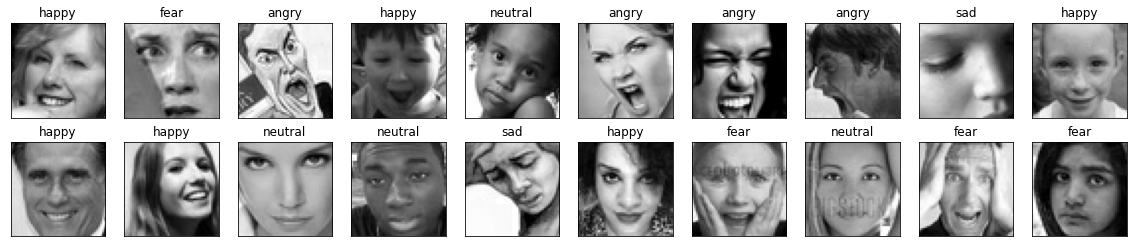

In [9]:
fig=plt.figure(figsize=(20,4))

for i in range(20):

            t=fig.add_subplot(2,10,i+1)
            # set the title of the image equal to its label
            t.set_title(str(dataset.class_names[labels[i].numpy()]))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(np.squeeze(imgs[i]),cmap='gray')

## Building the model

In [10]:
def get_model(nb_classes=7):
    model = Sequential()
    model.add(Input(shape=(image_size[0],image_size[1],1)))
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))
        
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.5))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation = 'softmax', name = 'Output'))
    model.summary()
    return model

### Add optimizer, loss and metrics

In [11]:
model=get_model(nb_classes=7)
model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 256)       2

If we already have pretrained weights then run for just one epoch.

In [12]:
try:
  model.load_weights("emotions_weights.h5")
  epochs=3
except:
  epochs=20

## Run optimizer

In [13]:
model.fit(dataset,validation_data=test_dataset,epochs=epochs)

Epoch 1/3
449/449 [==============================] - 21s 48ms/step - loss: 0.8570 - accuracy: 0.6821 - val_loss: 1.0840 - val_accuracy: 0.6119
Epoch 2/3
449/449 [==============================] - 21s 47ms/step - loss: 0.8303 - accuracy: 0.6938 - val_loss: 1.0956 - val_accuracy: 0.6094
Epoch 3/3
449/449 [==============================] - 21s 47ms/step - loss: 0.7984 - accuracy: 0.7049 - val_loss: 1.0812 - val_accuracy: 0.6088


Save the weights for later retrival and evaluate the model on the test data

In [14]:
model.save_weights("emotions_weights.h5")
model.evaluate(test_dataset)

113/113 [==============================] - 3s 28ms/step - loss: 1.0812 - accuracy: 0.6088


[1.0812113285064697, 0.6088047027587891]

# Prediction Accuracy and Confusion Matrix

In [15]:
probabilities=model.predict(test_dataset)
predictions=np.argmax(probabilities,axis=1)
print(predictions[0:10])
predictions.shape

[0 0 5 3 0 2 0 0 5 0]


(7178,)

### Combine the "true" labels into an array

In [16]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y.shape

(7178,)

### Count the number of correct and wrong predictions

In [17]:

compare=y==predictions
unique,count=np.unique(compare,return_counts=True)
print(unique)
print(count)

[False  True]
[2808 4370]


### Confusion Matrix
The percentage of correct/wrong predictions doesn't tell the whole story. Some emotions are more correctly predicted than others. Towards that end we compute the confusion matrix

In [18]:
m=tf.math.confusion_matrix(y,predictions)
m

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[ 486,   10,   87,   78,  112,  165,   20],
       [  23,   62,    5,    5,    3,   11,    2],
       [ 112,    6,  384,   64,  143,  213,  102],
       [  51,    1,   46, 1468,  112,   59,   37],
       [  93,   10,   60,  104,  738,  207,   21],
       [ 158,    3,  111,  102,  257,  598,   18],
       [  24,    2,   61,   56,   30,   24,  634]], dtype=int32)>

In [19]:
totals=np.sum(m.numpy(),axis=1)

for i in range(7):
  print("{}={:.3f}".format(dataset.class_names[i],m[i,i].numpy()/totals[i]))

angry=0.507
disgust=0.559
fear=0.375
happy=0.828
neutral=0.599
sad=0.480
surprise=0.763


### Plotting the Confusion Matrix

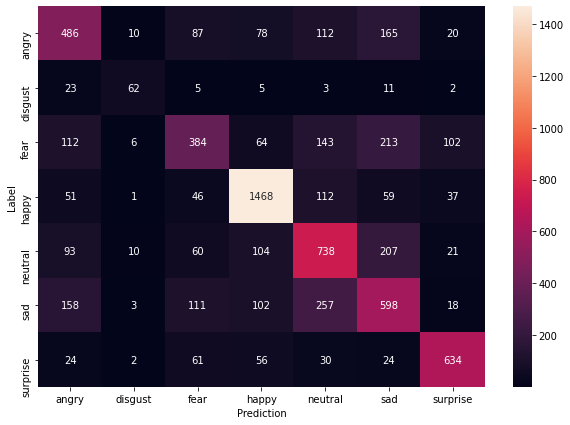

In [20]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(m, xticklabels=dataset.class_names, yticklabels=dataset.class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Classifying your own photo

In this part you will take a photo of yourself and classify it using a similar model. We will keep only 3 states : sad, happy and neutral. The easiest way is to delete the images for all the other categories and reload the dataset

In [21]:
!rm -rf train/disgust train/fear train/angry train/surprise

In [22]:
image_size=(48,48)
self_dataset=tf.keras.preprocessing.image_dataset_from_directory("train",batch_size=64,image_size=image_size, shuffle=True,color_mode="grayscale")
model=get_model(nb_classes=3)
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])


Found 17010 files belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_7 (Co

In [24]:
try:
  model.load_weights("self_weights.h5")
  epochs=1
except:
  epochs=20

In [25]:
model.fit(self_dataset,epochs=epochs)

266/266 [==============================] - 21s 79ms/step - loss: 0.4505 - accuracy: 0.8157


In [26]:
model.save_weights("self_weights.h5")


In [27]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))


In [28]:
img=take_photo(size=(256,256))

### Use OpenCV for face detection

import the opencv package and download the haarcascade classifier

In [29]:
import cv2
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2020-11-15 07:25:02--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.01s   

2020-11-15 07:25:03 (75.8 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [30]:
classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
## convert to gray scale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
##get the bounding box of the face
bboxes = classifier.detectMultiScale(img)
bboxes=np.squeeze(bboxes)
x,y,width,height=bboxes
## extract the face
face=img[x:x+width,y:y+height]
face = cv2.resize(face, (48,48), interpolation = cv2.INTER_CUBIC)


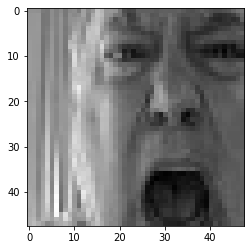

In [31]:
plt.imshow(face,cmap="gray")

Our model expects the input of shape (1,48,48,1). Use numpy expand_dims

In [32]:
r=np.expand_dims(face,0)
r=np.expand_dims(r,3)
res=model.predict(r)
print(self_dataset.class_names[np.argmax(res)])
print(res)

sad
[[0.12110575 0.37348273 0.5054115 ]]
